### Setup

In [1]:
import pandas as pd

from collections import Counter, defaultdict

import re

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Import

In [2]:
from os import path

directory = 'data'
file_name = 'NYC_RealEstate_Data.json'

data = pd.read_json(path.join(directory, file_name))

In [3]:
data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,1465733967000,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue
10,1.0,0,0,1460596230000,New to the market! Spacious studio located in ...,York Avenue,[],low,40.7769,6869199,-73.9467,e32475a6134d6d18279946b7b20a0f12,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue
100,1.0,2,e3ea799fc85b5ed5a65cb662e6eebafa,1460523347000,Beautiful 2 Bed apartment in bustling ...,8518 3rd Avenue,[],medium,40.6240,6866364,-74.0312,6f63020874d0bac3287ec5cdf202e270,[https://photos.renthop.com/2/6866364_50f3ac50...,2000,8518 3rd Avenue
1000,1.0,1,db572bebbed10ea38c6c47ab41619059,1460433932000,Amazing building in a Prime location! just ste...,W 57 St.,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",medium,40.7670,6859853,-73.9841,2b14eec3be2c4d669ce5949cf863de6f,[https://photos.renthop.com/2/6859853_db2bbf20...,3275,322 W 57 St.


### Cleaning Features

Since the listed features for each property do not follow a consistent naming pattern, a regex dictionary will need to be put together to parse appropriate features from each listing.

In [6]:
# These are some of the recurring features noted throughout the data.
# Ones that have been omitted were either insignificant in frequency or subjective descriptors

regex_dict = {'doorman': 'doorm[ae]n',
              'elevator': 'elev',
              'laundry': 'la?u?ndry',
              'gym': '(gym|fitness|exercise studio|yoga|health club)(?!.?discount)',
              'gym discount': '(gym|fitness|exercise studio|yoga|health club).?discount',
              'pets allowed': '(pet|dog|cat)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|dog|cat))',
              'cats allowed': '(pet|cat)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|cat))',
              'dogs allowed': '(pet|dog)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|dog))',
              'no pets': '(no (pet|dog|cat)|((pet|dog|cat)s? not allow))',
              'dishwasher': 'dishwash?er',
              'furnished': 'furnished',
              'prewar': 'pre.?war',
              'pool': 'pool',
              'balcony': 'balcon|balocn',
              'hardwood': 'hard.?wood|oak.?floor',
              'garden/patio':'garden|patio',
              'dining room': 'dining',
              'renovated':'renovat|reno\.',
              'washer/dryer':'^(?=.*dryer)(?=.*washer(?<!dishwasher)).*$',
              'washer': 'washer(?<!dishwasher)',
              'dryer': 'dryer',
              'garage': 'garage',
              'granite': 'granite',
              'view': 'view',
              'heat included': 'heat.?included',
              'hot water included': 'hot.?water.?included',
              'jacuzzi': 'jacuzzi',
              'parking': 'parking',
              'king size br': 'king',
              'queen size br': 'queen',
              'high ceilings': 'hi|high.?ceil',
              'loft': 'loft',
              'marble bath': 'marble bath',
              'no fee': 'no( broker)? fee',
              'new construction': 'new const',
              'giftcard': 'gift.?card',
              'outdoor space': 'outdoor',
              'playroom/nursery': 'play.?room|nursery',
              'postwar': 'post.?war',
              'yard': 'yard',
              'quiet': 'quiet',
              'deck': 'deck',
              'roof': 'roof',
              'skylight': 'sky.?light',
              'ss appliances': '(ss|stainless.?ste.l) appl',
              'ss kitchen': '(ss|stainless.?ste.l) kitch',
              'valet': 'valet',
              'intercom': 'intercom',
              'walk in closet': 'walk.?in.?closet',
              'fireplace': 'fireplace',
              'wheelchair access': 'wheelchair',
              'wi-fi': 'wi.?fi|internet|wireless',
              'residents lounge': 'lounge',
              'microwave': 'microwave',
              'low rise': 'low.?rise',
              'hi rise': 'hi.?rise',
              'live in super': 'live.?in.?super|super.?on.?site|on.?site.?super',
              'luxury': 'luxury',
              'exposed brick': 'exposed brick',
              'basement': 'basement',
              'storage': 'storage',
              'green': 'green',
              'concierge': 'concierge',
              'ac': 'ac|a/c|air cond|central.?air',
              'ceiling fan': 'ceiling.?fan',
              'bike room': 'bike|bicycle',
              'sunlight':'sun.?light|bright|sunny|natural.?light|lot.?s of light',
              'high-end kitchen': 'chef.?s? kitch|gourmet kitch',
              'closet space': 'closet',
              'housekeeping': 'housekeep|maid',
              'sauna': 'sauna',
              'simplex': 'simplex',
              'shuttle': 'shuttle',
              'spa': 'spa\b',
              'multi-level':'multi.?level'}

In [7]:
# Following fuction built to take in the regex dictionary and return the various lists & counts of what was found.
# This was procedurally used whilst expanding the regex dictionary.
def clean_features(f, regex_dict, return_discard=False, return_simplify=False):
    
    features = []
    discard = []
    simplify = defaultdict(list)
    
    f = f.lower()
    
    def get_feature(regex, search_str, label):
        if re.search(regex, search_str):
            features.append(label)
            if return_simplify:
                simplify[label].append(search_str)
            return True
        else:
            return False
    
    try:
        match = False
        
        for f_label, regex in regex_dict.items():
            flag = get_feature(regex, f, f_label)
            match = match if match else flag
        if not match:
            discard.append(f)
    
    except Exception as e:
        print(e)
        print(f)
        print(regex)
    
    return_list  = [features]
    if return_discard:
        return_list.append(discard) # Dictionary of items that were found to have no match in the regex dictionary
    if return_simplify:
        return_list.append(simplify) # Dictionary of items that were 'simplified' / identified as being a certain feature, along with their original text
    
    return return_list

In [8]:
# Build the 3 dictionaries for testing the regex results and identifying missing & mistaken features.

feature_dict = Counter()
discard_dict = Counter()
simplify_dict = defaultdict(list)

for i, row in data.iterrows():
    for feature in row['features']:
        
        feature_list, discard, simplify = clean_features(feature, regex_dict, True, True)
        
        for f in feature_list:
            feature_dict[f] += 1
        for f in discard:
            discard_dict[f] += 1
        for f, list_item in simplify.items():
            for item in list_item:
                if item not in simplify_dict[f]:
                    simplify_dict[f] += list_item

In [9]:
# Counts of all identified features
feature_dict

Counter({'ac': 12852,
         'balcony': 3141,
         'basement': 31,
         'bike room': 138,
         'cats allowed': 23729,
         'ceiling fan': 4,
         'closet space': 184,
         'concierge': 212,
         'deck': 7170,
         'dining room': 5151,
         'dishwasher': 20816,
         'dogs allowed': 22214,
         'doorman': 21155,
         'dryer': 457,
         'elevator': 26279,
         'exposed brick': 132,
         'fireplace': 976,
         'furnished': 690,
         'garage': 1033,
         'garden/patio': 2269,
         'giftcard': 3,
         'granite': 137,
         'green': 253,
         'gym': 13516,
         'gym discount': 2,
         'hardwood': 24621,
         'heat included': 3,
         'hi rise': 24,
         'high ceilings': 5404,
         'high-end kitchen': 42,
         'hot water included': 8,
         'housekeeping': 20,
         'intercom': 18,
         'jacuzzi': 8,
         'king size br': 776,
         'laundry': 29758,
         'liv

In [10]:
# Features that found no match and have been discarded
discard_dict

Counter({'!!!!low fee!!!!': 1,
         '$250 security deposit': 1,
         '$500 security deposit': 1,
         "** holy deal batman! * sprawling 3br home * cook's kitchen * 2 blks to waterfront * bedford l stop **": 1,
         '** huge true 3br home * mr clean approved * massive windows galore * steps to the park & bedford l stop **': 1,
         "** huge true 3br home * the perfect share * massive windows galore * cook's kitchen * steps to l train **": 1,
         '** oversized 2br super share * french doors * ss eat-in kitchen * mr clean approved * heart of midtown! **': 1,
         "** rent stabilized * oversized 1br home * mr clean approved * separate cook's kitchen * heart of midtown **": 1,
         "** sprawling 2br super share * massive windows galore * cook's kitchen * 2 blks to bedford l stop **": 1,
         '** sprawling 3br super share * clean & brite * near waterfront! * 2 blks to bedford l stop **': 1,
         '** the perfect share! * sprawling sunfilled 4br mansion

In [11]:
# Example of items that were identified as a certain feature (for verifying no false matches)
simplify_dict['garage']

['garage',
 'on-site garage',
 'attached parking garage',
 'common parking/garage',
 'full service garage',
 'indoor garage available',
 '• on-site lifestyle concierge by luxury attaché •24/7 doorman • state of the art cardiovascular and weight training equipment • 24-hour valet parking garage • valet services including dry cleaning',
 'parking garage',
 'garage.',
 'garage fitness facility laundry room valet lounge billiards room rooftop deck wifi access',
 'garage parking!',
 'garage parking',
 'attended garage and service entrance',
 'on-site attended garage',
 '24-hour parking garage with an electric vehicle charging station.',
 'attended garage',
 'garage attached',
 'private garage available',
 'attached garage',
 'on-site parking garage']

Many of the features identified above are not of much use due to their infrequency. For the sake of both a more reliable set of data and decluttering the amount of features that will be analyzed, only those with 500 or more records will be kept.

In [12]:
feature_dict_reduced = {key: value for key, value in feature_dict.items() if value > 500}

In [13]:
feature_dict_reduced

{'ac': 12852,
 'balcony': 3141,
 'cats allowed': 23729,
 'deck': 7170,
 'dining room': 5151,
 'dishwasher': 20816,
 'dogs allowed': 22214,
 'doorman': 21155,
 'elevator': 26279,
 'fireplace': 976,
 'furnished': 690,
 'garage': 1033,
 'garden/patio': 2269,
 'gym': 13516,
 'hardwood': 24621,
 'high ceilings': 5404,
 'king size br': 776,
 'laundry': 29758,
 'live in super': 611,
 'loft': 2106,
 'low rise': 790,
 'multi-level': 637,
 'new construction': 2607,
 'no fee': 18102,
 'outdoor space': 7671,
 'parking': 744,
 'pets allowed': 45746,
 'pool': 3120,
 'prewar': 10517,
 'renovated': 556,
 'roof': 7153,
 'simplex': 908,
 'wheelchair access': 1390,
 'wi-fi': 4427}

In [14]:
regex_dict_reduced = {key: value for key, value in regex_dict.items() if key in feature_dict_reduced.keys()}

In [15]:
regex_dict_reduced

{'ac': 'ac|a/c|air cond|central.?air',
 'balcony': 'balcon|balocn',
 'cats allowed': '(pet|cat)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|cat))',
 'deck': 'deck',
 'dining room': 'dining',
 'dishwasher': 'dishwash?er',
 'dogs allowed': '(pet|dog)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|dog))',
 'doorman': 'doorm[ae]n',
 'elevator': 'elev',
 'fireplace': 'fireplace',
 'furnished': 'furnished',
 'garage': 'garage',
 'garden/patio': 'garden|patio',
 'gym': '(gym|fitness|exercise studio|yoga|health club)(?!.?discount)',
 'hardwood': 'hard.?wood|oak.?floor',
 'high ceilings': 'hi|high.?ceil',
 'king size br': 'king',
 'laundry': 'la?u?ndry',
 'live in super': 'live.?in.?super|super.?on.?site|on.?site.?super',
 'loft': 'loft',
 'low rise': 'low.?rise',
 'multi-level': 'multi.?level',
 'new construction': 'new const',
 'no fee': 'no( broker)? fee',
 'outdoor space': 'outdoor',
 'parking': 'parking',
 'pets allowed': '(pet|dog|cat)(?!s?(.?are)?.?not (allow|ok))(?<!no (pet|dog|cat))',
 'pool': 

Next step is to take the regex dictionary and build a basic true/false table, which marks which features each property has.

In [16]:
def set_features(data, regex_dict):
    
    d = []
    
    for index, row in data.iterrows():
        
        f_dict = {label: 0 for label in regex_dict}
        
        for feature in row['features']:
            for label, regex in regex_dict.items():
                if re.search(regex, feature.lower()):
                    f_dict[label] = 1
        
        d.append(f_dict)
    
    df = pd.DataFrame(d, index=data.index)
    
    return df

In [17]:
df = set_features(data, regex_dict_reduced)

In [18]:
feature_data = pd.merge(data[['interest_level','features']], df, left_index=True, right_index=True)

In [19]:
feature_data

,interest_level,features,ac,balcony,cats allowed,deck,dining room,dishwasher,dogs allowed,doorman,...,outdoor space,parking,pets allowed,pool,prewar,renovated,roof,simplex,wheelchair access,wi-fi
0,medium,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,low,"[Doorman, Elevator, Fitness Center, Cats Allow...",0,0,1,0,0,0,1,1,...,0,0,1,0,0,0,0,0,0,0
10,low,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,medium,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000,medium,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",0,0,1,1,0,1,1,1,...,0,0,1,1,0,0,1,0,0,1
10000,medium,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",0,0,0,1,0,1,0,1,...,0,0,0,1,0,0,1,0,0,1
10001,low,"[Cats Allowed, Dogs Allowed, Elevator]",0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
10002,low,"[Cats Allowed, Dogs Allowed]",0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
10003,medium,[],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10004,low,"[Laundry in Building, Laundry in Unit, Swimmin...",0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,0,0,0


### Feature Analysis

Using the feature_data table, we can proceed with counting the occurances of each feature per interest level to see if any features are prevalent in high interest listings.

In [20]:
n_feature_data = feature_data.groupby('interest_level').sum().reindex(['low', 'medium','high'])
n_feature_data

,ac,balcony,cats allowed,deck,dining room,dishwasher,dogs allowed,doorman,elevator,fireplace,...,outdoor space,parking,pets allowed,pool,prewar,renovated,roof,simplex,wheelchair access,wi-fi
interest_level,,,,,,,,,,,,,,,,,,,,,
low,5943,1989,17107,4881,3260,13598,16130,15400,18267,756,...,4671,425,17126,2218,7847,226,4850,807,917,2769
medium,2654,836,4904,1849,1452,5691,4530,4509,6163,181,...,2090,171,4913,711,2096,234,1850,79,362,1298
high,819,256,1613,427,439,1525,1462,1112,1811,38,...,652,74,1621,167,574,96,429,22,111,354


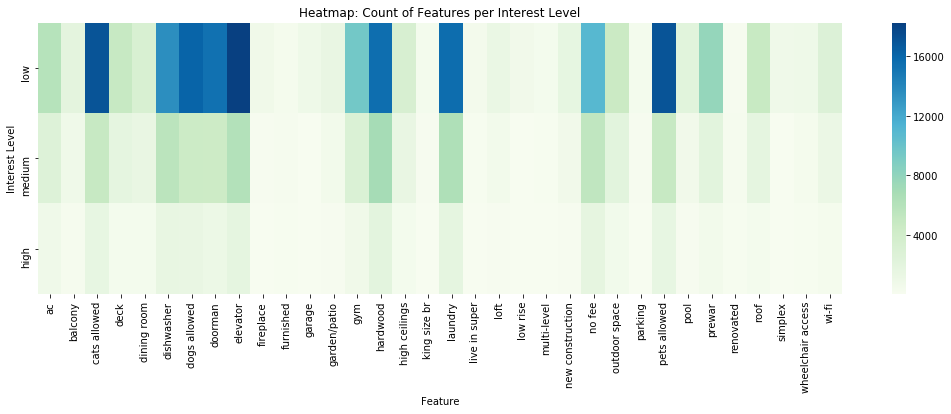

In [21]:
plt.figure(figsize=(18,5))

ax = sns.heatmap(n_feature_data, cmap='GnBu')

ax.set_title('Heatmap: Count of Features per Interest Level')
ax.set_xlabel('Feature')
ax.set_ylabel('Interest Level')

plt.show()

Unfortunately this does not give us much information since the high number of low interest listings drowns out the results for high interest which we are interested in.

To address this, we will take the mean occurance (ranging from 0 to 1) of each feature per interest level.

In [22]:
p_feature_data = feature_data.groupby('interest_level').mean().reindex(['low', 'medium','high'])
p_feature_data

,ac,balcony,cats allowed,deck,dining room,dishwasher,dogs allowed,doorman,elevator,fireplace,...,outdoor space,parking,pets allowed,pool,prewar,renovated,roof,simplex,wheelchair access,wi-fi
interest_level,,,,,,,,,,,,,,,,,,,,,
low,0.173630,0.058110,0.499795,0.142603,0.095244,0.397277,0.471252,0.449924,0.533686,0.022087,...,0.136467,0.012417,0.500351,0.064801,0.229257,0.006603,0.141697,0.023577,0.026791,0.080899
medium,0.236437,0.074477,0.436882,0.164722,0.129354,0.506993,0.403563,0.401693,0.549042,0.016125,...,0.186192,0.015234,0.437684,0.063341,0.186726,0.020846,0.164811,0.007038,0.032249,0.115635
high,0.213559,0.066754,0.420600,0.111343,0.114472,0.397653,0.381226,0.289961,0.472229,0.009909,...,0.170013,0.019296,0.422686,0.043546,0.149674,0.025033,0.111864,0.005737,0.028944,0.092308


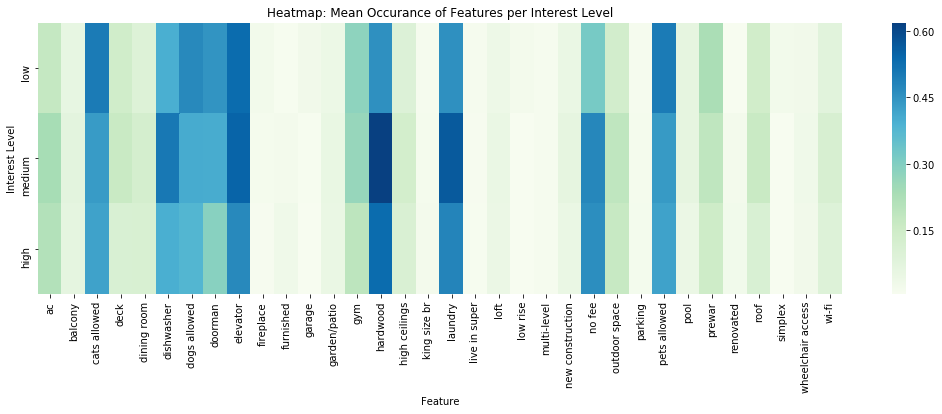

In [23]:
plt.figure(figsize=(18,5))

ax = sns.heatmap(p_feature_data, cmap='GnBu')

ax.set_title('Heatmap: Mean Occurance of Features per Interest Level')
ax.set_xlabel('Feature')
ax.set_ylabel('Interest Level')

plt.show()

In [24]:
m_feature_data = p_feature_data.divide(p_feature_data.mean(), axis=1).sub(1)
m_feature_data

,ac,balcony,cats allowed,deck,dining room,dishwasher,dogs allowed,doorman,elevator,fireplace,...,outdoor space,parking,pets allowed,pool,prewar,renovated,roof,simplex,wheelchair access,wi-fi
interest_level,,,,,,,,,,,,,,,,,,,,,
low,-0.164740,-0.125462,0.104702,0.021833,-0.157309,-0.084561,0.125565,0.182374,0.029647,0.376988,...,-0.169017,-0.206540,0.103130,0.132301,0.215879,-0.622567,0.016059,0.945757,-0.086510,-0.159759
medium,0.137396,0.120845,-0.034357,0.180329,0.144491,0.168256,-0.036106,0.055625,0.059274,0.005269,...,0.133766,-0.026519,-0.035032,0.106790,-0.009686,0.191634,0.181800,-0.419186,0.099609,0.201021
high,0.027344,0.004616,-0.070345,-0.202162,0.012818,-0.083695,-0.089459,-0.238000,-0.088922,-0.382257,...,0.035251,0.233059,-0.068098,-0.239091,-0.206193,0.430933,-0.197859,-0.526572,-0.013099,-0.041262


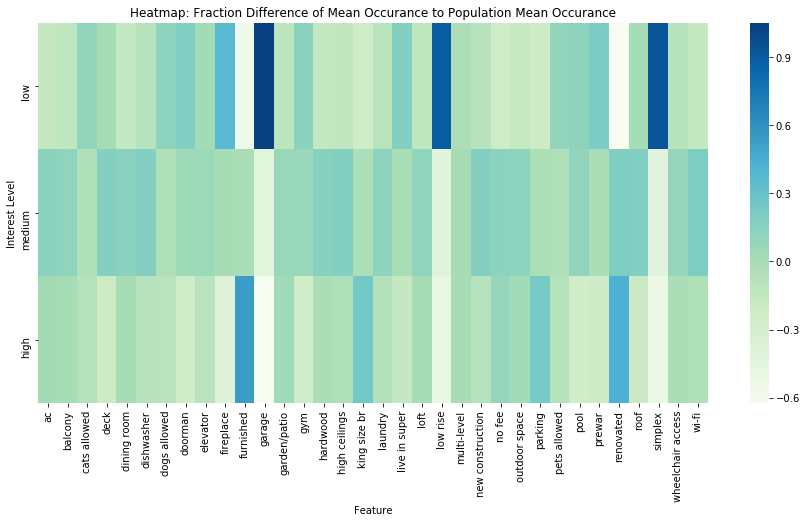

In [25]:
plt.figure(figsize=(15,7))

ax = sns.heatmap(m_feature_data, cmap='GnBu')

ax.set_title('Heatmap: Fraction Difference of Mean Occurance to Population Mean Occurance')
ax.set_xlabel('Feature')
ax.set_ylabel('Interest Level')

directory = 'figures'
file_name = 'Features_Heatmap_Mean Delta.png'
plt.savefig(path.join(directory, file_name))

plt.show()

### Other Misc. Attributes

Photos and description have been left unexplored so far. Whilst analyzing the contents of these two attributes is beyond the scope of this project, one can at least see if there is any connection between the presence and number/length of these attributes.

In [4]:
# Get integer value for interest level, with optional weights provided
def get_ilevel_int(ilevel, weights=[-1,0,1]):
    try:
        if ilevel == 'high':
            ilevel_int = weights[2]
        elif ilevel == 'medium':
            ilevel_int = weights[1]
        elif ilevel == 'low':
            ilevel_int = weights[0]
        else:
            ilevel_int = 0
    except Exception as e:
        print(e, ': ', ilevel)
        ilevel_int=0
    
    return ilevel_int

In [5]:
# Column for number of photos, and flag for has photos
data['n_photos'] = data['photos'].apply(lambda x: len(x))
data['has_photos'] = data['n_photos'] > 0

# Column for number of features, and flag for has features
data['n_features'] = data['features'].apply(lambda x: len(x))
data['has_features'] = data['n_features'] > 0

# Column for length of description, and flag for has description
data['desc_length'] = data['description'].apply(lambda x: len(x))
data['has_desc'] = data['desc_length'] > 0

# Column for interest level integer value, with weights of 0, 0.5 and 1 for low, medium and high
data['interest_level_int'] = data['interest_level'].apply(lambda x: get_ilevel_int(x, [0,0.5,1]))

data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,photos,price,street_address,n_photos,has_photos,n_features,has_features,desc_length,has_desc,interest_level_int
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,5,True,0,False,588,True,0.5
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,1465733967000,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,11,True,5,True,8,True,0.0
10,1.0,0,0,1460596230000,New to the market! Spacious studio located in ...,York Avenue,[],low,40.7769,6869199,...,[https://photos.renthop.com/2/6869199_06b2601f...,1950,1661 York Avenue,1,True,0,False,168,True,0.0
100,1.0,2,e3ea799fc85b5ed5a65cb662e6eebafa,1460523347000,Beautiful 2 Bed apartment in bustling ...,8518 3rd Avenue,[],medium,40.6240,6866364,...,[https://photos.renthop.com/2/6866364_50f3ac50...,2000,8518 3rd Avenue,5,True,0,False,526,True,0.5
1000,1.0,1,db572bebbed10ea38c6c47ab41619059,1460433932000,Amazing building in a Prime location! just ste...,W 57 St.,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",medium,40.7670,6859853,...,[https://photos.renthop.com/2/6859853_db2bbf20...,3275,322 W 57 St.,4,True,12,True,542,True,0.5


In [23]:
data['desc_length'].max()

4466

In [24]:
print('Max n_photos = {}'.format(data['n_photos'].max()))
print('Max n_features = {}'.format(data['n_features'].max()))
print('Max desc. length = {}'.format(data['desc_length'].max()))

Max n_photos = 68
Max n_features = 39
Max desc. length = 4466


In [25]:
photo_bins = list(range(0,75,5))
feature_bins = list(range(0,45,5))
desc_bins = list(range(0,5000,100))

In [26]:
def get_int_bin(value, bins):
    try:
        lower = bins[0]

        if value < lower:
            return lower

        for i, b in enumerate(bins):
            upper = b
            if value <= upper:
                return upper
            lower = b

        return upper
    except:
        return 'N/A'

In [27]:
data['photo_bin'] = data['n_photos'].apply(lambda x: get_int_bin(x, photo_bins))
data['feature_bin'] = data['n_features'].apply(lambda x: get_int_bin(x, feature_bins))
data['desc_bin'] = data['desc_length'].apply(lambda x: get_int_bin(x, desc_bins))

data.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,n_photos,has_photos,n_features,has_features,desc_length,has_desc,interest_level_int,photo_bin,feature_bin,desc_bin
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,1466754864000,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,...,5,True,0,False,588,True,0.5,5,0,600
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,1465733967000,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,...,11,True,5,True,8,True,0.0,15,5,100
10,1.0,0,0,1460596230000,New to the market! Spacious studio located in ...,York Avenue,[],low,40.7769,6869199,...,1,True,0,False,168,True,0.0,5,0,200
100,1.0,2,e3ea799fc85b5ed5a65cb662e6eebafa,1460523347000,Beautiful 2 Bed apartment in bustling ...,8518 3rd Avenue,[],medium,40.6240,6866364,...,5,True,0,False,526,True,0.5,5,0,600
1000,1.0,1,db572bebbed10ea38c6c47ab41619059,1460433932000,Amazing building in a Prime location! just ste...,W 57 St.,"[Swimming Pool, Roof Deck, Doorman, Elevator, ...",medium,40.7670,6859853,...,4,True,12,True,542,True,0.5,5,15,600


In [28]:
data.groupby('interest_level')['n_photos'].mean()

interest_level
high      5.738462
low       5.521357
medium    5.813274
Name: n_photos, dtype: float64

Means above show high and medium interest tend have just slightly more photos, but all means are in the 5.5-6.0 range.

In [29]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

data.groupby('photo_bin')['interest_level_int'].size().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[0])
axs[0].set_title('Count')
axs[0].set_xlabel('Number of Photos')
axs[0].set_ylabel('Count')

data.groupby('photo_bin')['interest_level_int'].mean().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[1])
axs[1].set_title('Mean Interest Level')
axs[1].set_xlabel('Number of Photos')
axs[1].set_ylabel('Mean Interest Level (0-1)')

fig.suptitle('Bar Charts: Number of Photos (Binned)')

directory = 'figures'
file_name = 'Features_Bar Chart_N Photos.png'
fig.savefig(path.join(directory, file_name))

#plt.show()
plt.close()

![](./figures/Features_Bar Chart_N Photos.png)

One can note a sharp decline in interest level for the ~4000 listings with 0-5 photos, vs. those with 5 or more.

In [30]:
data.groupby('interest_level')['has_photos'].mean()

interest_level
high      0.986962
low       0.899585
medium    0.989042
Name: has_photos, dtype: float64

In [31]:
# Fraction of missing photos that are low interest
len(data[(~data['has_photos']) & (data['interest_level'] == 'low')])/len(data[(~data['has_photos'])])

0.9520775623268698

In [45]:
# Fraction of not missing photos that are low interest
len(data[(data['has_photos']) & (data['interest_level'] == 'low')])/len(data[(data['has_photos'])])

0.6740881824948552

Reconfirming the statement above, significantly more low interest listings are missing photos entirely.

In [32]:
data.groupby('interest_level')['n_features'].mean()

interest_level
high      5.160365
low       5.307789
medium    5.889176
Name: n_features, dtype: float64

No real upward or downward trend in means across the interest levels for the number of features.

In [33]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

data.groupby('feature_bin')['interest_level_int'].size().plot.bar(align='edge', width=1, edgecolor='k', ax=axs[0])
axs[0].set_title('Count')
axs[0].set_xlabel('Number of Features')
axs[0].set_ylabel('Count')

data.groupby('feature_bin')['interest_level_int'].mean().plot.bar(align='edge', width=1, edgecolor='k',ax=axs[1])
axs[1].set_title('Mean Interest Level')
axs[1].set_xlabel('Number of Features')
axs[1].set_ylabel('Mean Interest Level (0-1)')

fig.suptitle('Bar Charts: Number of Features (Binned)')

directory = 'figures'
file_name = 'Features_Bar Chart_N Features.png'
fig.savefig(path.join(directory, file_name))

#plt.show()
plt.close()

![](./figures/Features_Bar Chart_N Features.png)

Number of features listed seems to have little impact on interest level. The higher range bins with the sharp increase in interest level are due to the limited number of items in those bins:

In [34]:
data[data['n_features'] > 35]

,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,...,n_photos,has_photos,n_features,has_features,desc_length,has_desc,interest_level_int,photo_bin,feature_bin,desc_bin
35882,2.0,2,f173cada34706987817637348a4bfe8e,1463491838000,Amazing concessions - ONE MONTH FREE AND NO BR...,NO FEE LIMITED TIME!*1 MO FREE!!!*REAL 2BD/2BA...,"[Common Outdoor Space, Laundry In Unit, Cats A...",medium,40.7443,7023617,...,6,True,36,True,1544,True,0.5,10,40,1600
36740,1.0,1,0,1463418210000,THIS IS An Extremely Rare TRUE 1 Bedroom apart...,NO FEE ** 1 MONTH FREE** BEST DEAL ON MARKET**...,"[Common Outdoor Space, Laundry In Unit, Cats A...",medium,40.7442,7020221,...,6,True,39,True,1311,True,0.5,10,40,1400


In [35]:
data.groupby('interest_level')['has_features'].mean()

interest_level
high      0.899087
low       0.938910
medium    0.934788
Name: has_features, dtype: float64

In [42]:
# Fraction of missing features that are low interest
len(data[(~data['has_features']) & (data['interest_level'] == 'low')])/len(data[(~data['has_features'])])

0.6514018691588785

In [47]:
# Fraction not missing features that are low interest
len(data[(data['has_features']) & (data['interest_level'] == 'low')])/len(data[(data['has_features'])])

0.6974478058943531

In [52]:
len(data[(~data['has_features'])])

3210

In [51]:
len(data[(~data['has_features']) & (~data['has_desc'])])

58

High interest listings actually have less features listed, on average.

In [36]:
data.groupby('interest_level')['desc_length'].mean()

interest_level
high      608.510039
low       584.372122
medium    653.508953
Name: desc_length, dtype: float64

Low interest listings have slightly shorter descriptions, on average, but only in the magnitude of 30-50 characters which is not very significant for actual written word.

In [37]:
fig, axs = plt.subplots(1,2,figsize=(15,5))

data.groupby('desc_bin')['interest_level_int'].size().plot.bar(align='edge', width=1, edgecolor='k',ax=axs[0])
axs[0].set_title('Count')
axs[0].set_xlabel('Description Length')
axs[0].set_ylabel('Count')

data.groupby('desc_bin')['interest_level_int'].mean().plot.bar(align='edge', width=1, edgecolor='k',ax=axs[1])
axs[1].set_title('Mean Interest Level')
axs[1].set_xlabel('Description Length')
axs[1].set_ylabel('Mean Interest Level (0-1)')

fig.suptitle('Bar Charts: Description Length (Binned)')

directory = 'figures'
file_name = 'Features_Bar Chart_Description.png'
fig.savefig(path.join(directory, file_name))

#plt.show()
plt.close()

![](./figures/Features_Bar Chart_Description.png)

The absence of, or having a description shorter than 200 characters, is where a noticeable drop in mean interest level occurs. Past that point, however, there seems to be little gained from longer descriptions, with some of the longer descriptions even showing a slight reduction in interest (ignoring the anomalies at 2700-2800 and 3100-3200 where there are not enough records to form a reliable mean).

In [38]:
data.groupby('interest_level')['has_desc'].mean()

interest_level
high      0.988787
low       0.961172
medium    0.993675
Name: has_desc, dtype: float64

In [43]:
# Fraction of listings missing descriptions that are low interest
len(data[(~data['has_desc']) & (data['interest_level'] == 'low')])/len(data[(~data['has_desc'])])

0.920997920997921

In [46]:
# Fraction not missing descriptions that are low interest
len(data[(data['has_desc']) & (data['interest_level'] == 'low')])/len(data[(data['has_desc'])])

0.6876162608423033